<a href="https://colab.research.google.com/github/devashish-roy/gated-recurrent-unit-GRU-/blob/main/GRU_GestureAnalysis_OnOriginalData_LabelPerTimeStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implemenataion of GRU for the gesture classification**  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Start from here, if re-running. Data is already pre-processed and saved in this xls. The code for pre-processing the data is in other notebook GRU_GestureAnalysis.ipynb

In [ ]:
# the pre-processed data xls
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Advance data mining/preprocessed_data.xlsx')

In [ ]:
# Remove name column
data = data.drop('name_encoded', axis=1)

# Drop columns for new features added in pre-processong. Those columns starts with column name Dist_Join*
cols_to_drop = data.filter(like='Dist_Join', axis=1).columns  # Find columns starting with 'Dist_Join'

# Drop the identified columns
data = data.drop(columns=cols_to_drop)

In [ ]:
# copy the data to preprocessed_data
preprocessed_data = data.copy()

In [ ]:
preprocessed_data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x18,y18,z18,x19,y19,z19,x20,y20,z20,action_encoded
0,-0.377219,0.676463,2.477132,-0.367249,0.493018,2.566909,-0.529421,0.355840,2.576270,-0.194301,...,-0.229579,-0.865148,2.683695,-0.466046,-0.898524,2.631478,-0.207994,-0.936921,2.647322,0
1,-0.376956,0.676517,2.476770,-0.366931,0.492976,2.566630,-0.529115,0.355951,2.576212,-0.194166,...,-0.229124,-0.866005,2.683765,-0.484327,-0.924024,2.698534,-0.207764,-0.937304,2.633385,0
2,-0.377076,0.676532,2.476376,-0.366147,0.492745,2.566584,-0.528687,0.355584,2.575751,-0.194098,...,-0.229045,-0.866254,2.684294,-0.484638,-0.926029,2.699292,-0.207359,-0.937390,2.639276,0
3,-0.377247,0.675063,2.476167,-0.366134,0.492734,2.566559,-0.528485,0.355650,2.575728,-0.194087,...,-0.229039,-0.866281,2.684332,-0.466230,-0.898756,2.632194,-0.209036,-0.937718,2.646430,0
4,-0.377483,0.674604,2.476354,-0.366084,0.492718,2.566469,-0.528106,0.355623,2.575532,-0.194132,...,-0.228421,-0.867698,2.685030,-0.466177,-0.899217,2.631851,-0.209116,-0.938717,2.646000,0


Split the data in Train (70%), validation(15%) and test(15%) set

In [ ]:
# Splitting Dataset into training, validation and testing sets
from sklearn.model_selection import train_test_split
X = preprocessed_data.iloc[:, :-1]
y = preprocessed_data.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=True)


print(X_train.shape, X_test.shape, X_val.shape)

print(y_train.shape, y_test.shape, y_val.shape)

(140737, 60) (30158, 60) (30159, 60)
(140737, 1) (30158, 1) (30159, 1)


Normalise the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
X_train

array([[0.10872339, 0.46836816, 0.62495789, ..., 0.0956619 , 0.31411227,
        0.57542542],
       [0.40416339, 0.68069644, 0.6595241 , ..., 0.49425943, 0.34971033,
        0.45172809],
       [0.58278039, 0.53529359, 0.34242867, ..., 0.5959725 , 0.30973242,
        0.39405931],
       ...,
       [0.48661945, 0.53567732, 0.22114891, ..., 0.53996868, 0.30253429,
        0.2886285 ],
       [0.3207362 , 0.61609575, 0.67416212, ..., 0.35802198, 0.39781302,
        0.56254864],
       [0.4212638 , 0.60557459, 0.67484357, ..., 0.40594062, 0.33479483,
        0.56961769]])

In [ ]:
X_train.shape

(140737, 60)

In [ ]:
y_train.shape

(140737, 1)

**Implementation of GRU**

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size

        # Weights for the update gate
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)

        # Weights for the reset gate
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)

        # Weights for the candidate hidden state
        self.W_h = nn.Linear(input_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h_prev):
        # Update gate
        z_t = torch.sigmoid(self.W_z(x) + self.U_z(h_prev))

        # Reset gate
        r_t = torch.sigmoid(self.W_r(x) + self.U_r(h_prev))

        # Candidate hidden state
        h_tilde = torch.tanh(self.W_h(x) + r_t * self.U_h(h_prev))

        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t


In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Stack multiple GRU cells for multi-layer GRU
        self.gru_cells = nn.ModuleList([GRUCell(input_size, hidden_size)] +
                                       [GRUCell(hidden_size, hidden_size) for _ in range(num_layers - 1)])

        # Fully connected layer for classification output (output_size = number of classes)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_length, input_size = x.size()

        # Initialize hidden states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]

        # Store outputs for every time step
        outputs = []

        # Process each time step
        for t in range(seq_length):
            x_t = x[:, t, :] # shape (batch_size, input_size (i.e. 64,79))..For all the sequences(64) in the batch, get all the features (79) at 't' timestep
            for i in range(self.num_layers):
                h_t[i] = self.gru_cells[i](x_t, h_t[i])
                x_t = h_t[i]  # Output of one layer is the input to the next layer
            # Compute output for each time step using the last hidden state
            output = self.fc(h_t[-1])  # Shape (batch_size, output_size)
            outputs.append(output.unsqueeze(1))  # Append output of shape (batch_size, 1, output_size)

        # Output layer using the hidden state from the last layer
        #print("h_t shape", h_t[-1].shape)
        #out = self.fc(h_t[-1])  # No softmax here; it will be handled by the loss function
        #print("out shape", out.shape)

        # Concatenate outputs along the time dimension
        outputs = torch.cat(outputs, dim=1)  # Shape (batch_size, seq_length, output_size)

        return outputs


In [ ]:
# Define sequence length (e.g., 10 time steps per sequence)
sequence_length = 10

# Function to create sequences of data for GRU
def create_sequences(x, y, sequence_length):
    sequences = []
    labels = []
    for i in range(len(x) - sequence_length):
        # Create a sequence of `sequence_length` time steps
        sequences.append(x[i:i + sequence_length])
        #break
        # Take the corresponding label from the last time step of the sequence
        labels.append(y[i:i + sequence_length])

    return np.array(sequences), np.array(labels)

# Apply the function to your dataset
X_train_sequences, y_train_sequences = create_sequences(X_train, y_train, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test, y_test, sequence_length)
X_val_sequences, y_val_sequences = create_sequences(X_val, y_val, sequence_length)

# Print shapes to verify
print(f"X_train_sequences shape: {X_train_sequences.shape}")  # Should be (num_sequences, sequence_length, input_size), (140727, 10, 79)
print(f"y_train_sequences shape: {y_train_sequences.shape}")  # Should be (num_sequences, 1), (140727, 10, 1)
print(f"X_test_sequences shape: {X_test_sequences.shape}")
print(f"y_test_sequences shape: {y_test_sequences.shape}")
print(f"X_val_sequences shape: {X_val_sequences.shape}")
print(f"y_val_sequences shape: {y_val_sequences.shape}")
#print(X_train_sequences[0])
#print(y_train_sequences[0])

X_train_sequences shape: (140727, 10, 60)
y_train_sequences shape: (140727, 10, 1)
X_test_sequences shape: (30148, 10, 60)
y_test_sequences shape: (30148, 10, 1)
X_val_sequences shape: (30149, 10, 60)
y_val_sequences shape: (30149, 10, 1)


Train and Test with gesture analysis data

In [ ]:
#from itertools import count
# Hyperparameters
input_size = len(preprocessed_data.columns) - 1                       # Number of features in the input - 60
hidden_size = 128                                                     # Number of hidden units in each GRU cell
num_layers = 2                                                        # Number of GRU layers
output_size = len(preprocessed_data['action_encoded'].unique())       # Number of classes for classification - 30
learning_rate = 0.001

# Initialize the model, criterion, and optimizer
model = GRUNet(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Example training loop
num_epochs = 10
batch_size = 64

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.long)
x_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.long)
x_val_tensor = torch.tensor(X_val_sequences, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_sequences, dtype=torch.long)

# Create a DataLoader for batching
train_data = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
val_data = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

Train and validate the model

Epoch [1/10], Training Loss: 1.2970, Validation Loss: 0.7854,Training Accuracy: 56.71%,Validation Accuracy: 73.69%
Epoch [2/10], Training Loss: 0.5756, Validation Loss: 0.4559,Training Accuracy: 81.50%,Validation Accuracy: 85.37%
Epoch [3/10], Training Loss: 0.3420, Validation Loss: 0.3068,Training Accuracy: 89.68%,Validation Accuracy: 90.44%
Epoch [4/10], Training Loss: 0.2215, Validation Loss: 0.2261,Training Accuracy: 93.63%,Validation Accuracy: 92.95%
Epoch [5/10], Training Loss: 0.1508, Validation Loss: 0.1766,Training Accuracy: 95.86%,Validation Accuracy: 94.65%
Epoch [6/10], Training Loss: 0.1059, Validation Loss: 0.1347,Training Accuracy: 97.23%,Validation Accuracy: 95.95%
Epoch [7/10], Training Loss: 0.0767, Validation Loss: 0.1171,Training Accuracy: 98.11%,Validation Accuracy: 96.31%
Epoch [8/10], Training Loss: 0.0577, Validation Loss: 0.1019,Training Accuracy: 98.64%,Validation Accuracy: 96.72%
Epoch [9/10], Training Loss: 0.0455, Validation Loss: 0.0966,Training Accuracy: 

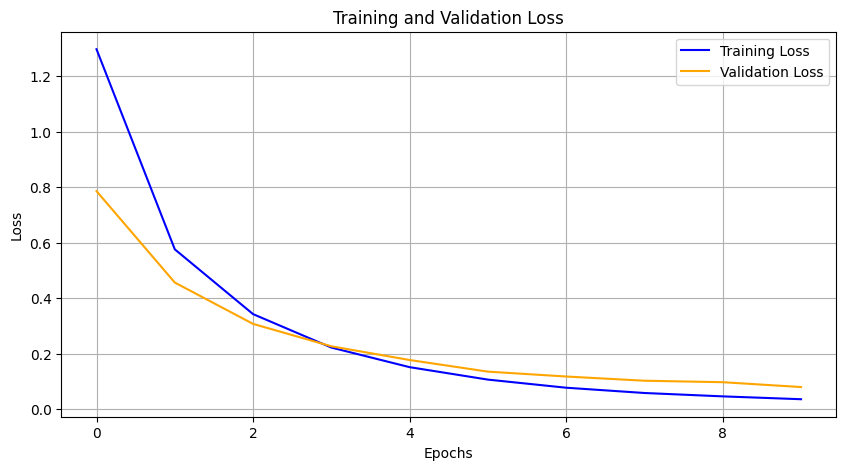

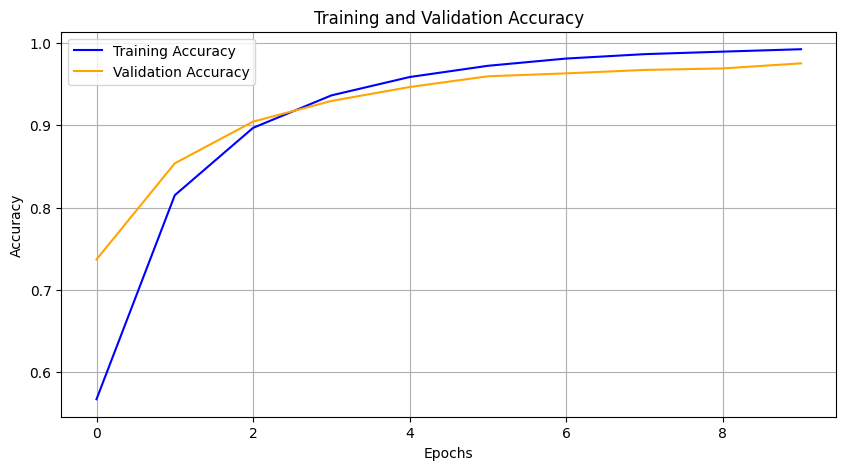

In [ ]:
# Lists to store the loss values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for train_x, train_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        train_outputs = model(train_x)  # Shape: (batch_size, sequence_length, output_size)

        _, train_predicted = torch.max(train_outputs, dim=-1)  # Get predicted labels (shape: batch_size, sequence_length)

        # Prepare for calculating accuracy
        train_y = train_y.squeeze(-1)  # Now shape: (64, 10) # Squeeze the last dimension of train_y
        train_total += train_y.size(0) * train_y.size(1)
        train_correct += (train_predicted == train_y).sum().item()

        # Reshape output for loss calculation
        # CrossEntropyLoss expects (batch_size * sequence_length, output_size)
        # Targets should be (batch_size * sequence_length)
        train_loss = criterion(train_outputs.view(-1, output_size), train_y.view(-1))

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # collect losses
        train_running_loss += train_loss.item()

    # Average loss for the epoch
    avg_train_loss = train_running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Training accuracy per epoch
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

#   Model evaluation using validation data set
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_outputs = None
    val_targets = None

    with torch.no_grad():  # Disable gradient calculations for inference
        val_correct = 0
        val_total = 0

        for val_x, val_y in val_loader:
            val_outputs = model(val_x)
            _, predicted = torch.max(val_outputs, dim=-1)  # Get predicted labels (shape: batch_size, sequence_length)

            val_loss = criterion(val_outputs.view(-1, output_size), val_y.view(-1))  # Calculate validation loss
            val_running_loss += val_loss.item()

            # Prepare for calculating accuracy
            val_y = val_y.squeeze(-1)  # Squeeze the last dimension of batch_y. Now shape: (64, 10)
            val_total += val_y.size(0) * val_y.size(1)
            val_correct += (predicted == val_y).sum().item()


        # Average validation loss
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # validation accuracy per epoch
        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)
        #print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Print training and validation loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}'f', Training Accuracy: {train_accuracy * 100:.2f}%' f', Validation Accuracy: {val_accuracy * 100:.2f}%')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save the model
model_path = '/content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_Gesture_Analysis_OnOriginalData_model.pth'  #path
torch.save(model.state_dict(), model_path)


Test the model using test set

In [ ]:
# Load the model
model_path = '/content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_Gesture_Analysis_OnOriginalData_model.pth'  #path
model = GRUNet(input_size, hidden_size, output_size, num_layers) # Reinitialize the model
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode after loading
print(f'Model loaded from {model_path}')


# Initialize variables to calculate accuracy
test_correct = 0
test_total = 0

# Disable gradient calculation for inference
with torch.no_grad():
    for test_x, test_y in test_loader:  # Assuming you have a test_loader
        # Forward pass through the model
        test_outputs = model(test_x)  # Shape: (batch_size, seq_length, num_classes)

        # Get the indices of the max logit values along the last dimension (num_classes)
        _, predicted_indices = torch.max(test_outputs, dim=-1)  # Shape: (batch_size, seq_length)


        # Squeeze batch_y to remove the last dimension
        test_y = test_y.squeeze(-1)  # Now shape: (batch_size, seq_length)

        # Calculate total counts
        test_total += test_y.numel()  # Total number of labels in the test set
        test_correct += (predicted_indices == test_y).sum().item()  # Compare predictions with true labels

# Calculate accuracy
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Model loaded from /content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_Gesture_Analysis_OnOriginalData_model.pth
Test Accuracy: 97.63%
